In [1]:
import torch
from torch import nn
torch.__version__
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cuda


Data folder path: D:\Programming\Projects\Facial_Emotion_Recognition\data
Random image path:..\data\train\neutral\Training_53071098.jpg
Image class:neutral
Image height:48
Image width: 48


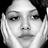

In [2]:
from pathlib import Path
from PIL import Image
import random

# go up one level to reach project root
image_path = Path("../data")

print(f"Data folder path: {image_path.resolve()}")

if not image_path.exists():
    raise FileNotFoundError(f"Data folder not found at {image_path.resolve()}")

# collect all jpgs (train/test/class/image.jpg)
image_path_list = list(image_path.glob("*/*/*.jpg"))

if not image_path_list:
    raise ValueError("No images found inside data folder")

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path:{random_image_path}")
print(f"Image class:{image_class}")
print(f"Image height:{img.height}")
print(f"Image width: {img.width}")
img


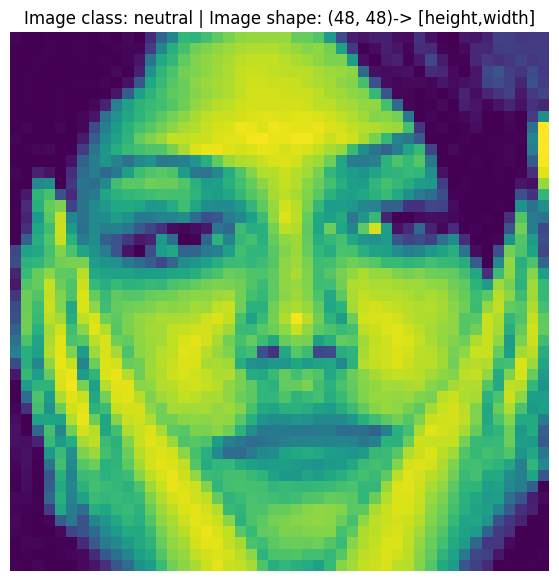

In [3]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}-> [height,width]")
plt.axis(False)

image_height = img_as_array.shape[0]
image_width = img_as_array.shape[1]

In [4]:
img_as_array.shape

(48, 48)

In [5]:
train_dir = image_path /"train"
test_dir = image_path/"test"

train_dir,test_dir

(WindowsPath('../data/train'), WindowsPath('../data/test'))

Transforming Data

In [6]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Training transformations (with mild augmentation)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),   # <--- convert 1→3
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),         # small left-right flips
    transforms.RandomRotation(10),                  # small angle variation
    transforms.ToTensor(),                          # convert to tensor
    transforms.Normalize((0.5,), (0.5,))            # normalize for faster learning
])

# Testing transformations (no augmentation)
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),   # <--- convert 1→3
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [14]:
print("Length of training dataset:", len(train_data))
print("Length of test dataset:", len(test_data))

Length of training dataset: 28709
Length of test dataset: 7178


In [8]:
import torch
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, dropout_rate: float = 0.3):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> 48x48 -> 24x24
            nn.Dropout2d(p=dropout_rate)  # dropout after conv block
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> 24x24 -> 12x12
            nn.Dropout2d(p=dropout_rate)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*2*12*12, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),  # regularize before final output
            nn.Linear(in_features=128, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


In [16]:
import torch
from torch import nn

class MediumCNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=7):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),

            # Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),

            # Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [9]:
from re import L
def train_step(model : torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device : torch.device = device):
  model.train()
  train_loss,train_acc = 0,0
  model.to(device)
  for batch,(X,y) in enumerate (data_loader):
    X, y = X.to(device), y.to(device)

    #forward pass
    y_pred = model(X)

    #calc loss
    loss=loss_fn(y_pred,y)
    train_loss +=loss.item()

    #optimizer zero grad
    optimizer.zero_grad()


    #loss backward
    loss.backward()

    #optimizer step
    optimizer.step()

    #calc accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc +=(y_pred_class==y).sum().item()/len(y_pred)

  #calc loss and acc per epoch and print out whats happeneing
  train_loss /=len(data_loader)
  train_acc /=len(data_loader)
  return train_loss,train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model:torch.nn.Module,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  test_loss,test_acc = 0,0
  model.to(device)
  model.eval()

  with torch.inference_mode():

    for X,y in (data_loader):
      X,y = X.to(device),y.to(device)

      #forward pass
      test_pred = model(X)

      #calc loss
      loss = loss_fn(test_pred,y)
      test_loss+=loss.item()

      #calc acc
      test_pred_labels = test_pred.argmax(dim=1)
      test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

    #adjust metrics and print out
    test_loss/=len(data_loader)
    test_acc /=len(data_loader)
    return test_loss,test_acc

In [10]:
from tqdm import tqdm
#create a func that takes in  various model parameters
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn =nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
  #create empty results dict
  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]}
  #loop thru train and test steps for a number of steps
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train_step(model = model,
                                      data_loader = train_dataloader,
                                      loss_fn = loss_fn,
                                      optimizer = optimizer,
                                      device = device)
    test_loss,test_acc = test_step(data_loader = test_dataloader,
                                   model = model,
                                   loss_fn = loss_fn,
                                   device = device)
    #print out
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    #update results dict
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)

    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [11]:

model_1 = TinyVGG(input_shape =3,
                   hidden_units =32,
                   output_shape = 7).to(device)
print(model_1)

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.3, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=7, bias=True)
  )
)


In [12]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import time
NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(params = model_1.parameters(),
                              lr = 0.001)
start_time = time.time()

model_1_results = train(model = model_1,
                        train_dataloader = train_loader,
                        test_dataloader = test_loader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS,
                        device = device)
end_time = time.time()
print(f"Total training time: {end_time-start_time: .3f} seconds")

 20%|██        | 1/5 [00:24<01:36, 24.08s/it]

Epoch: 0 | Train Loss: 1.7276 | Train Acc: 0.3048 | Test Loss: 1.5629 | Test Acc: 0.3923


 40%|████      | 2/5 [00:48<01:12, 24.02s/it]

Epoch: 1 | Train Loss: 1.5447 | Train Acc: 0.4022 | Test Loss: 1.3916 | Test Acc: 0.4650


 60%|██████    | 3/5 [01:13<00:49, 24.88s/it]

Epoch: 2 | Train Loss: 1.4456 | Train Acc: 0.4447 | Test Loss: 1.3230 | Test Acc: 0.4958


 80%|████████  | 4/5 [01:48<00:28, 28.75s/it]

Epoch: 3 | Train Loss: 1.3963 | Train Acc: 0.4615 | Test Loss: 1.2726 | Test Acc: 0.5190


100%|██████████| 5/5 [02:15<00:00, 27.14s/it]

Epoch: 4 | Train Loss: 1.3588 | Train Acc: 0.4822 | Test Loss: 1.2510 | Test Acc: 0.5203
Total training time:  135.700 seconds


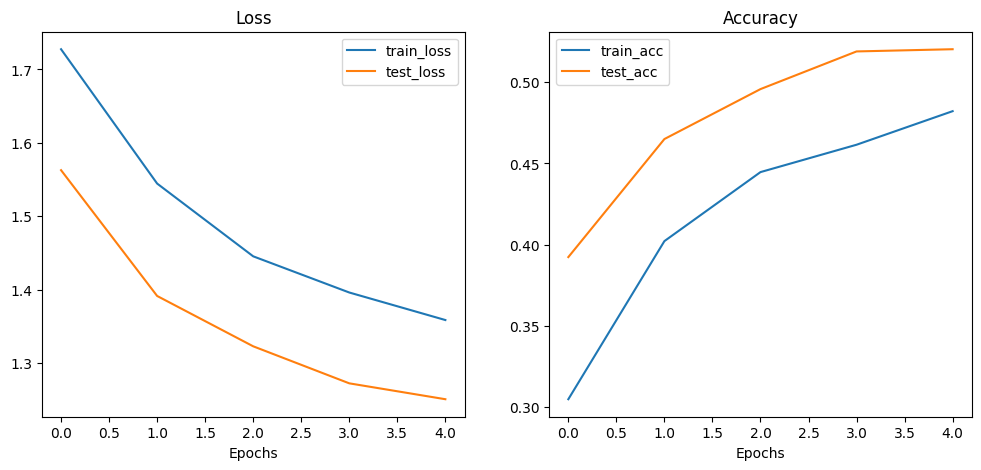

In [13]:
import matplotlib.pyplot as plt
def plot_loss_curves(results: dict):
  """
  Returns separate loss curves for training and test metrics.
  """
  #get loss values from results
  train_loss = results["train_loss"]
  test_loss = results["test_loss"]

  #get acc values from results
  train_acc = results["train_acc"]
  test_acc = results["test_acc"]

  #figure out number of epochs
  epochs = range(len(results["train_loss"]))

  #plot loss
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot(epochs,train_loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #plot acc
  plt.subplot(1,2,2)
  plt.plot(epochs,train_acc,label="train_acc")
  plt.plot(epochs,test_acc,label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()
  plt.show()
plot_loss_curves(model_1_results)


In [ ]:
model_2 = MediumCNN(input_channels=3, num_classes=7).to(device)
print(model_2)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import time
NUM_EPOCHS = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)
start_time = time.time()
model_2_results = train(model=model_2,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        loss_fn=loss_fn,
                        optimizer=optimizer)
end_time = time.time()
print(f"Total training time: {end_time - start_time: .3f} seconds")
plot_loss_curves(model_2_results)


MediumCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.3, inplace

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:24<01:36, 24.01s/it]

Epoch: 0 | Train Loss: 1.7637 | Train Acc: 0.2802 | Test Loss: 1.6802 | Test Acc: 0.3339


 40%|████      | 2/5 [00:48<01:12, 24.22s/it]

Epoch: 1 | Train Loss: 1.5932 | Train Acc: 0.3731 | Test Loss: 1.4396 | Test Acc: 0.4479


 60%|██████    | 3/5 [01:12<00:48, 24.34s/it]

Epoch: 2 | Train Loss: 1.5248 | Train Acc: 0.4011 | Test Loss: 1.4155 | Test Acc: 0.4566


 80%|████████  | 4/5 [01:38<00:24, 24.68s/it]

Epoch: 3 | Train Loss: 1.4832 | Train Acc: 0.4145 | Test Loss: 1.3342 | Test Acc: 0.4856
